# E-tivity 2 (06/02/23 - 19/02/23)

* Your Name: Zheng Hanming

* Your Student ID: 21225621

## Outline

This e-tivity is split into two parts. The first part <a href="#part1">**Stock Predicition**</a> is a group activity where you are tasked with predicting the stock market.

The second <a href="#part2">**Sentiment Analysis**</a> is an individual task, the problem is to predict if a film review is positive or negative.

### Guidelines

The e-tivity is split into five tasks. The first four are "group" excersises, in that you post the solutions to Tasks 1-4 to Gitlab. This will allow the members of your group to send you feedback (via the forums) so you can improve your submission. The final task is an individual task and together with the other tasks, should be uploaded to Sulis but not to gitlab.

Marks will be deducted if task 5 is posted to gitlab in contravention of instructions. Also if the the final submission is not a single notebook with tasks 1-5 and with correct identification or filename.


Grading guidelines: the grades for each task are additive, max 20. Weight [5/7]

**Task 1 [0-6]**: Complete with suitable preprocessing steps. There is no unique solution but you should justify the actions you are taking.

**Task 2 [0-4]**: Complete with suitable treatment of missing values. Again there maybe more than one solution, the important thing is to justify your actions.

**Tasks 3+4 [0-4]**: Create a suitable model with correct evaluation. Test for common DL issues.

**Task 5 [0-6]**: Completion of Task 5, using the layers outlined. The purpose of the task is to demonstrate that you can construct a valid model from scratch. Direct copy and paste from the web is not acceptable.

<a id='part1'></a>
## Stock Prediction

### Context

There is a small dataset of real stock prices for each working day from the end of 2015 to the end of 2019. There are four variables (with a time stamp), stock price, oil price, gold price and Euro to Dollar exchange. You need to predict the Stock price a day ahead from only the past values of each of the 4 variables. 


### Tasks 1-4 (complete by Monday 13/02/23)

These tasks are to be completed and uploaded to GitLab on which the other group members can comment. The forum activity will form part of the overall mark for the e-tivity.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping


**Task 1: data preprocessing**

Explain any preprocessing steps you take including but limited to reformatting and also how you have selected the training and test sets. The test set should be 20% of the whole.


In [2]:
df = pd.read_csv('./stock.csv')
print('Data Count:', df.shape)

Data Count: (1033, 5)


Adjusting Data To Align Input & Output<br>
- X consists of **all the columns** without the **last row**. This is because we need to predict stock price based on yesterday's data. Last row can only be used for the prediction of stock price that is not available. So it is removed.
- y consists of the **stock column** without the **first row**. This is because stock price is predicted using yesterday's data. No data is available to predict y on the first day (first row).

In [3]:
X = df[['Stock', 'Oil', 'EuroToDollar', 'Gold']].iloc[:-1]
y = df[['Stock']].iloc[1:]

In [4]:
df

Date        Stock        Oil  EuroToDollar    Gold
0     2015-11-23  2089.409912  41.490002        0.9432  1124.7
1     2015-11-24  2084.419922  42.040001        0.9388  1131.6
2     2015-11-25  2089.300049  42.689999        0.9420  1128.4
3     2015-11-27  2088.820068  43.250000        0.9438  1114.5
4     2015-11-30  2090.949951  41.770000        0.9468  1123.9
...          ...          ...        ...           ...     ...
1028  2019-12-24  3225.449951        NaN        0.9022  1518.6
1029  2019-12-26  3227.199951  61.200001        0.9007  1528.9
1030  2019-12-27  3247.229980  61.730000        0.8949  1540.7
1031  2019-12-30  3240.090088  61.709999        0.8915  1543.9
1032  2019-12-31  3215.179932  61.680000        0.8907  1546.7

[1033 rows x 5 columns]

In [5]:
shifted_data_check_df = X.copy(deep=True)
shifted_data_check_df['Target(ShiftedPrice)'] = y.copy(deep=True).values
shifted_data_check_df

Stock        Oil  EuroToDollar    Gold  Target(ShiftedPrice)
0     2089.409912  41.490002        0.9432  1124.7           2084.419922
1     2084.419922  42.040001        0.9388  1131.6           2089.300049
2     2089.300049  42.689999        0.9420  1128.4           2088.820068
3     2088.820068  43.250000        0.9438  1114.5           2090.949951
4     2090.949951  41.770000        0.9468  1123.9           2082.929932
...           ...        ...           ...     ...                   ...
1027  3226.050049  60.410000        0.9016  1510.7           3225.449951
1028  3225.449951        NaN        0.9022  1518.6           3227.199951
1029  3227.199951  61.200001        0.9007  1528.9           3247.229980
1030  3247.229980  61.730000        0.8949  1540.7           3240.090088
1031  3240.090088  61.709999        0.8915  1543.9           3215.179932

[1032 rows x 5 columns]

There are missing values in column Oil and EuroToDollar

In [6]:
# check missing values
na_count = df.isna().sum()
print('Features with missing values')
na_count[na_count > 0]

Features with missing values


Oil             10
EuroToDollar    12
dtype: int64

<AxesSubplot:>

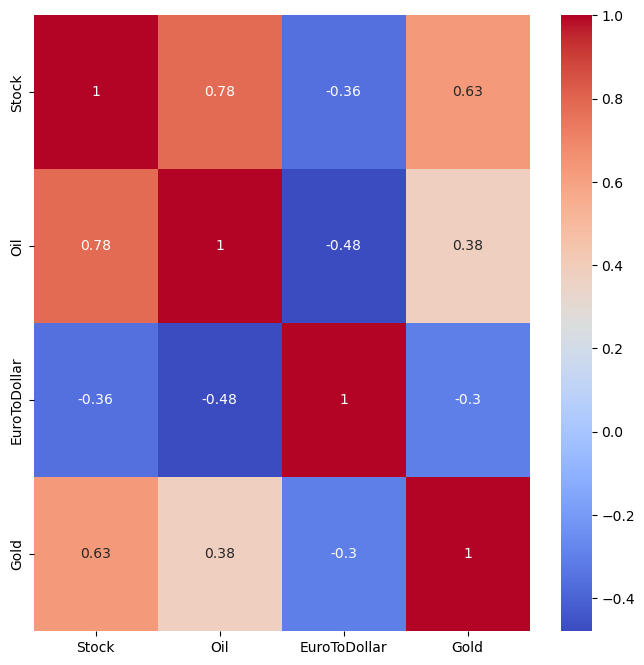

In [7]:
plt.figure(figsize=(8, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')

Data is split without change the order because this is a time series data

In [8]:
total = len(X)
total_80 = round(total * 0.8)
X_train = X.iloc[:total_80]
y_train = y.iloc[:total_80]
X_test = X.iloc[total_80:]
y_test = y.iloc[total_80:]

**Task 2: data cleaning**

There are a number of missing values in the data. Clean the data so that it is suitable for use with the NN. Bare in mind that you want to retain the time coherency of the data as much as possible.


Fixing Missing Value<br>
Go through each value and fill in the nan values using the below formula.<br>
missing value = previous value + (next value - previous value) / 2

In [9]:
for col in ['Oil', 'EuroToDollar']:
  for i, val in enumerate(X[col]):
    if math.isnan(val):
      prev = X[col][i-1]
      next = X[col][i+1]
      X[col][i] = (next - prev) / 2 + prev

**Task 3: model construction**

Construct a RNN network that will predict the future value of Stock, one day/time inteval in advance.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


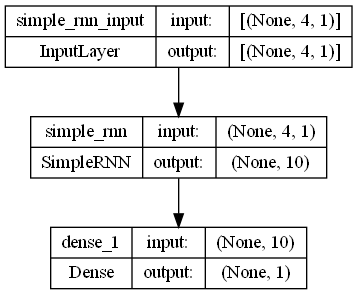

In [4]:
model = Sequential()
output_dim_RNN = 10
model.add(SimpleRNN(output_dim_RNN, input_shape=(4, 1), activation='linear'))
output_dim_Dense = 1
model.add(Dense(output_dim_Dense, activation='relu'))
model.compile(loss='mse', optimizer='adam')

model.summary()
plot_model(model, show_shapes=True)

Scale input data

In [11]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 300, restore_best_weights=True)

results = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    batch_size=128,
                    callbacks=[early_stopping],
                    epochs=1000)

Epoch 1/1000
7/7 [==============================] - 2s 83ms/step - loss: 5996429.5000 - val_loss: 8787280.0000
Epoch 2/1000
7/7 [==============================] - 0s 9ms/step - loss: 5996428.5000 - val_loss: 8787280.0000
Epoch 3/1000
7/7 [==============================] - 0s 8ms/step - loss: 5996416.5000 - val_loss: 8787280.0000
Epoch 4/1000
7/7 [==============================] - 0s 9ms/step - loss: 5996383.5000 - val_loss: 8787280.0000
Epoch 5/1000
7/7 [==============================] - 0s 9ms/step - loss: 5996321.0000 - val_loss: 8787188.0000
Epoch 6/1000
7/7 [==============================] - 0s 9ms/step - loss: 5996054.5000 - val_loss: 8785946.0000
Epoch 7/1000
7/7 [==============================] - 0s 9ms/step - loss: 5995396.0000 - val_loss: 8783562.0000
Epoch 8/1000
7/7 [==============================] - 0s 8ms/step - loss: 5994314.0000 - val_loss: 8780807.0000
Epoch 9/1000
7/7 [==============================] - 0s 9ms/step - loss: 5992841.5000 - val_loss: 8777714.0000
Epoch 10/

Epoch 76/1000
7/7 [==============================] - 0s 8ms/step - loss: 20046.4883 - val_loss: 34546.5352
Epoch 77/1000
7/7 [==============================] - 0s 8ms/step - loss: 19883.9043 - val_loss: 34658.4141
Epoch 78/1000
7/7 [==============================] - 0s 8ms/step - loss: 19725.5957 - val_loss: 34487.0625
Epoch 79/1000
7/7 [==============================] - 0s 8ms/step - loss: 19565.7207 - val_loss: 34117.4141
Epoch 80/1000
7/7 [==============================] - 0s 8ms/step - loss: 19407.9629 - val_loss: 33406.8594
Epoch 81/1000
7/7 [==============================] - 0s 8ms/step - loss: 19242.7832 - val_loss: 33267.4570
Epoch 82/1000
7/7 [==============================] - 0s 9ms/step - loss: 19081.5332 - val_loss: 33042.1172
Epoch 83/1000
7/7 [==============================] - 0s 9ms/step - loss: 18923.7539 - val_loss: 32816.6641
Epoch 84/1000
7/7 [==============================] - 0s 8ms/step - loss: 18764.2461 - val_loss: 31985.4512
Epoch 85/1000
7/7 [==================

7/7 [==============================] - 0s 9ms/step - loss: 9106.2764 - val_loss: 12928.9785
Epoch 153/1000
7/7 [==============================] - 0s 11ms/step - loss: 8990.1338 - val_loss: 12855.0996
Epoch 154/1000
7/7 [==============================] - 0s 8ms/step - loss: 8884.6221 - val_loss: 12963.6504
Epoch 155/1000
7/7 [==============================] - 0s 9ms/step - loss: 8761.5859 - val_loss: 12369.2236
Epoch 156/1000
7/7 [==============================] - 0s 8ms/step - loss: 8652.8594 - val_loss: 12156.8164
Epoch 157/1000
7/7 [==============================] - 0s 9ms/step - loss: 8538.8213 - val_loss: 11783.2715
Epoch 158/1000
7/7 [==============================] - 0s 9ms/step - loss: 8429.9004 - val_loss: 11597.3691
Epoch 159/1000
7/7 [==============================] - 0s 9ms/step - loss: 8325.0820 - val_loss: 11239.5195
Epoch 160/1000
7/7 [==============================] - 0s 9ms/step - loss: 8217.1133 - val_loss: 11483.1396
Epoch 161/1000
7/7 [==============================]

7/7 [==============================] - 0s 8ms/step - loss: 2940.6538 - val_loss: 2505.5576
Epoch 230/1000
7/7 [==============================] - 0s 8ms/step - loss: 2892.2971 - val_loss: 2401.8887
Epoch 231/1000
7/7 [==============================] - 0s 8ms/step - loss: 2846.8279 - val_loss: 2290.8184
Epoch 232/1000
7/7 [==============================] - 0s 8ms/step - loss: 2802.2339 - val_loss: 2277.5964
Epoch 233/1000
7/7 [==============================] - 0s 8ms/step - loss: 2756.3677 - val_loss: 2191.8811
Epoch 234/1000
7/7 [==============================] - 0s 8ms/step - loss: 2712.1936 - val_loss: 2151.4922
Epoch 235/1000
7/7 [==============================] - 0s 8ms/step - loss: 2670.0457 - val_loss: 2120.0613
Epoch 236/1000
7/7 [==============================] - 0s 8ms/step - loss: 2625.7766 - val_loss: 2052.8801
Epoch 237/1000
7/7 [==============================] - 0s 8ms/step - loss: 2584.2336 - val_loss: 2002.8668
Epoch 238/1000
7/7 [==============================] - 0s 8ms/

Epoch 307/1000
7/7 [==============================] - 0s 9ms/step - loss: 965.9744 - val_loss: 559.5797
Epoch 308/1000
7/7 [==============================] - 0s 9ms/step - loss: 956.5203 - val_loss: 561.0362
Epoch 309/1000
7/7 [==============================] - 0s 9ms/step - loss: 945.7695 - val_loss: 572.4785
Epoch 310/1000
7/7 [==============================] - 0s 8ms/step - loss: 936.9900 - val_loss: 577.7726
Epoch 311/1000
7/7 [==============================] - 0s 8ms/step - loss: 928.0788 - val_loss: 581.8947
Epoch 312/1000
7/7 [==============================] - 0s 8ms/step - loss: 919.0280 - val_loss: 582.2897
Epoch 313/1000
7/7 [==============================] - 0s 8ms/step - loss: 910.1052 - val_loss: 578.8970
Epoch 314/1000
7/7 [==============================] - 0s 8ms/step - loss: 902.8259 - val_loss: 585.7246
Epoch 315/1000
7/7 [==============================] - 0s 8ms/step - loss: 894.1490 - val_loss: 596.5419
Epoch 316/1000
7/7 [==============================] - 0s 8ms/ste

7/7 [==============================] - 0s 9ms/step - loss: 652.4514 - val_loss: 1232.1399
Epoch 386/1000
7/7 [==============================] - 0s 10ms/step - loss: 651.7124 - val_loss: 1184.5726
Epoch 387/1000
7/7 [==============================] - 0s 9ms/step - loss: 651.0064 - val_loss: 1180.9467
Epoch 388/1000
7/7 [==============================] - 0s 9ms/step - loss: 649.1866 - val_loss: 1219.0642
Epoch 389/1000
7/7 [==============================] - 0s 9ms/step - loss: 648.6259 - val_loss: 1212.7380
Epoch 390/1000
7/7 [==============================] - 0s 9ms/step - loss: 648.0760 - val_loss: 1223.8604
Epoch 391/1000
7/7 [==============================] - 0s 9ms/step - loss: 648.0419 - val_loss: 1284.6426
Epoch 392/1000
7/7 [==============================] - 0s 9ms/step - loss: 647.0350 - val_loss: 1266.2438
Epoch 393/1000
7/7 [==============================] - 0s 9ms/step - loss: 646.4117 - val_loss: 1228.0287
Epoch 394/1000
7/7 [==============================] - 0s 9ms/step - l

7/7 [==============================] - 0s 8ms/step - loss: 630.7196 - val_loss: 1587.8693
Epoch 464/1000
7/7 [==============================] - 0s 8ms/step - loss: 631.4265 - val_loss: 1591.1498
Epoch 465/1000
7/7 [==============================] - 0s 8ms/step - loss: 631.0306 - val_loss: 1549.2529
Epoch 466/1000
7/7 [==============================] - 0s 8ms/step - loss: 631.2775 - val_loss: 1600.7391
Epoch 467/1000
7/7 [==============================] - 0s 8ms/step - loss: 631.4071 - val_loss: 1505.2036
Epoch 468/1000
7/7 [==============================] - 0s 18ms/step - loss: 631.3091 - val_loss: 1487.9430
Epoch 469/1000
7/7 [==============================] - 0s 8ms/step - loss: 632.2554 - val_loss: 1583.0482
Epoch 470/1000
7/7 [==============================] - 0s 8ms/step - loss: 631.7007 - val_loss: 1516.4287
Epoch 471/1000
7/7 [==============================] - 0s 8ms/step - loss: 630.1057 - val_loss: 1565.0757
Epoch 472/1000
7/7 [==============================] - 0s 8ms/step - l

7/7 [==============================] - 0s 8ms/step - loss: 630.5981 - val_loss: 1699.3967
Epoch 542/1000
7/7 [==============================] - 0s 9ms/step - loss: 629.6213 - val_loss: 1570.9496
Epoch 543/1000
7/7 [==============================] - 0s 8ms/step - loss: 630.0772 - val_loss: 1549.5723
Epoch 544/1000
7/7 [==============================] - 0s 8ms/step - loss: 629.4037 - val_loss: 1641.7062
Epoch 545/1000
7/7 [==============================] - 0s 8ms/step - loss: 629.8801 - val_loss: 1665.3900
Epoch 546/1000
7/7 [==============================] - 0s 8ms/step - loss: 629.8272 - val_loss: 1623.6256
Epoch 547/1000
7/7 [==============================] - 0s 8ms/step - loss: 629.5833 - val_loss: 1582.9071
Epoch 548/1000
7/7 [==============================] - 0s 8ms/step - loss: 629.7325 - val_loss: 1570.1094
Epoch 549/1000
7/7 [==============================] - 0s 8ms/step - loss: 631.2538 - val_loss: 1616.7074
Epoch 550/1000
7/7 [==============================] - 0s 8ms/step - lo

**Task 4: test**

Evaluate the model on the test set and display any change in accuracy over time, if any. Test for common issues found ion deep learning models.

✔ Answer:<br>
Overfitting & Underfitting: These two issues are undesirable as they make the model performance worse than it should be. Between 200 to 300 epochs, the issues are minimized as the difference between training errors and validation errors are at minimum.<br>
Slow Convergence: The convergence of the model training is acceptable as we reach acceptable performance at 300 epochs.<br>
Generalization: The model performs relatively well on unseen data with model weights between 200 to 300 epochs.

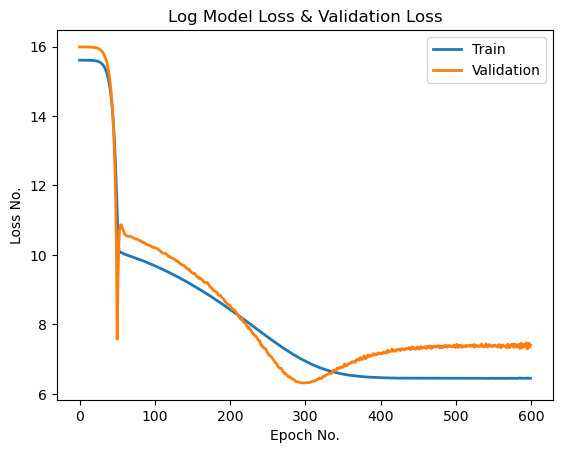

In [13]:
plt.plot(np.log(results.history['loss']), linewidth=2, label='Train')
plt.plot(np.log(results.history['val_loss']), linewidth=2, label='Validation')
plt.title('Log Model Loss & Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss No.')
plt.xlabel('Epoch No.')
plt.show()

33/33 [==============================] - 0s 2ms/step


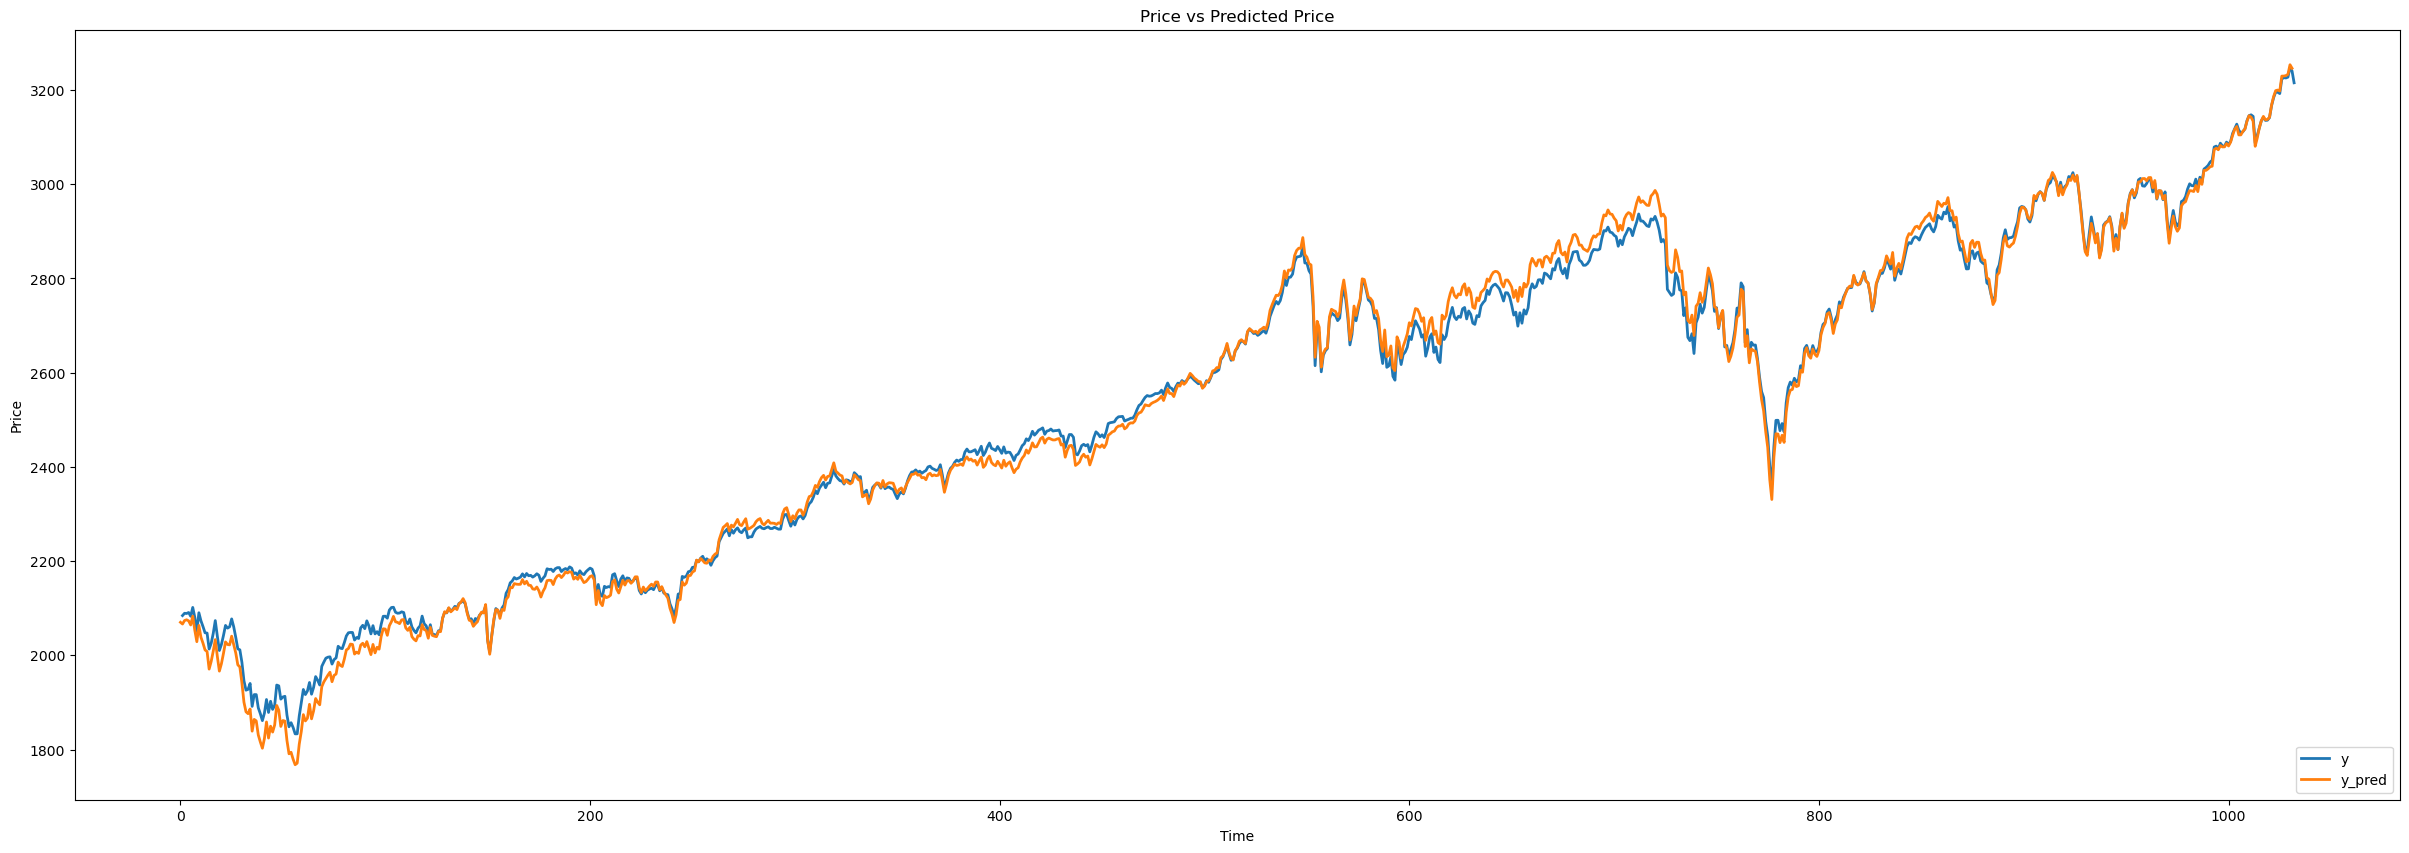

In [14]:
y_pred = model.predict(scaler.transform(X))
plt.figure(figsize=(30,10))
plt.plot(y, linewidth=2, label='y')
plt.plot(y_pred, linewidth=2, label='y_pred')
plt.title('Price vs Predicted Price')
plt.legend(loc='lower right')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show()

### Post (complete by Monday 13/02/23)

Post your solution to Tasks 1-4 in notebook form. If you have not completed all the tasks then that is acceptable. The purpose is to get feedback from others in the group, so if you have only a basic outline then you may get ideas about how to proceed and also examples from others in your group.

No posts should reference Task 5.

### Respond (complete by Wednesday 15/02/23)

If you feel you can provide useful advise then respond to another member of the group through the appropriate forum. Responses should be respectful and offer some sort of advise. Try and avoid clogging the forums with support or thank you messages.

In reviewing others code you will discover different ways to tackle the same problem. It is acceptable to copy parts of others code. However whole scale copying from another notebook is not acceptable.

Grading guidelines for the forum posts: Weight [2/7]

**Beginning [0-8]:** Respectful posts of minor value. Significant number of posts without valuable contributions and/or without well-considered questions. Posts about task 5 in contravention of instructions.

**Developing [9-12]:** At least 1 post  exceeding Beginning level with respectful suggestion or thought provoking question. Most posts contain valuable contributions or well-considered questions.

**Advancing [13-16]:** At least 2 posts: equal to or exceeding Beginning level;  with respectful and sound contribution highlighting mistakes or alternative approaches.

**Accomplished [17-20]:** At least 3 posts: equal to or exceeding Accomplished level; with respectful contribution of significant value. 

<a id='part2'></a>
## Sentiment Analysis


This task is a individual task and should **not** to be uploaded to GitHub. No direct support should be given via the forums, although comments about progress or results are allowed. Marks will be deducted if the instructions are not followed (see rubrics). This part should be uploaded directly to Sulis.

### Context

You have a model that predicts the sentiment of a film review (positive or negative) from the IMDB. There are two hyperparameters that format the data from IMDB: the maximum review length and the dictionary size. Below is a RNN model that predicts sentiment values. 


### Task 5:  (completed by Sunday 19/02/23)

Keeping top_words, max_review_lenngth and the embedding_vector_length the same, change the model so that it uses attention only, i.e. there are no recurrent components. The only Keras layers (defined here https://www.tensorflow.org/api_docs/python/tf/keras/layers) that you allowed to use are:
- Input,
- Embedding, 
- Dense, 
- Any Attention (must be at leat one),
- TimeDistributed,
- Any Merging,
- Any Reshaping,
- Any Pooling,
- Dropout. 

You need not use any of the layers (except attention) but you can use some more than once. Can you do at least as good as the RNN example?

**NB** There are many examples of using attention for sentiment analysis but we looking to see if you can construct a sensible model. The model will be delibrately restricted, so do not waste too much time achieving spectacular accuracy. Remember the rules of thumb that we discussed in the Introduction to DL module.


In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, MultiHeadAttention, Layer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import numpy as np

top_words = 100
(Rev_train, Sc_train), (Rev_test, Sc_test) = imdb.load_data(num_words=top_words)

max_review_length = 500
X_train = sequence.pad_sequences(Rev_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(Rev_test, maxlen=max_review_length)
print(X_train.shape)

(25000, 500)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 16)           1600      
                                                                 
 dropout (Dropout)           (None, 500, 16)           0         
                                                                 
 multi_head_attn (MultiHeadA  (None, 500, 16)          2160      
 ttn)                                                            
                                                                 
 lstm (LSTM)                 (None, 10)                1080      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                        

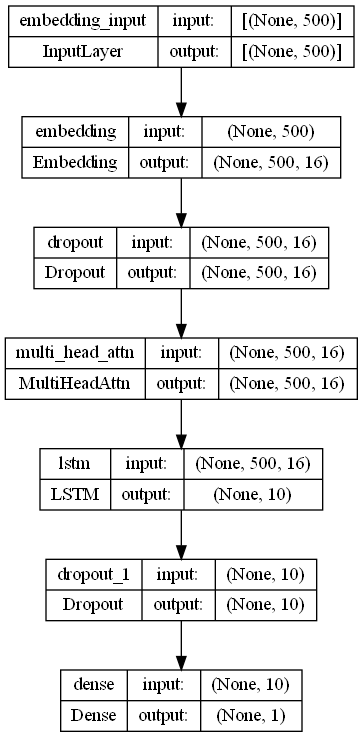

In [2]:
class MultiHeadAttn(Layer):
    def __init__(self, dimension, head_count):
        super().__init__()
        self.attention_layer = MultiHeadAttention(num_heads=head_count, key_dim=dimension)

    def call(self, inputs):
        return self.attention_layer(inputs, inputs)

embedding_vector_length = 16
model_imdb = Sequential()
model_imdb.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model_imdb.add(Dropout(0.2))
model_imdb.add(MultiHeadAttn(embedding_vector_length, 2))
model_imdb.add(LSTM(10))
model_imdb.add(Dropout(0.2))
model_imdb.add(Dense(1, activation='sigmoid'))
model_imdb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_imdb.summary())
plot_model(model_imdb,show_shapes=True)

In [24]:
nepoch = 150
IMDB_history = model_imdb.fit(X_train,Sc_train,validation_data=(X_test,Sc_test),epochs=nepoch,batch_size=256)


Epoch 1/150
98/98 [==============================] - 122s 1s/step - loss: 0.5126 - accuracy: 0.7433 - val_loss: 0.5208 - val_accuracy: 0.7396
Epoch 2/150
98/98 [==============================] - 121s 1s/step - loss: 0.5126 - accuracy: 0.7434 - val_loss: 0.5211 - val_accuracy: 0.7391
Epoch 3/150
98/98 [==============================] - 122s 1s/step - loss: 0.5129 - accuracy: 0.7436 - val_loss: 0.5209 - val_accuracy: 0.7382
Epoch 4/150
98/98 [==============================] - 121s 1s/step - loss: 0.5144 - accuracy: 0.7442 - val_loss: 0.5226 - val_accuracy: 0.7372
Epoch 5/150
98/98 [==============================] - 121s 1s/step - loss: 0.5136 - accuracy: 0.7440 - val_loss: 0.5228 - val_accuracy: 0.7384
Epoch 6/150
98/98 [==============================] - 122s 1s/step - loss: 0.5126 - accuracy: 0.7447 - val_loss: 0.5199 - val_accuracy: 0.7393
Epoch 7/150
98/98 [==============================] - 121s 1s/step - loss: 0.5123 - accuracy: 0.7428 - val_loss: 0.5247 - val_accuracy: 0.7367
Epoch 

98/98 [==============================] - 123s 1s/step - loss: 0.5091 - accuracy: 0.7455 - val_loss: 0.5198 - val_accuracy: 0.7421
Epoch 59/150
98/98 [==============================] - 122s 1s/step - loss: 0.5082 - accuracy: 0.7474 - val_loss: 0.5192 - val_accuracy: 0.7399
Epoch 60/150
98/98 [==============================] - 120s 1s/step - loss: 0.5097 - accuracy: 0.7470 - val_loss: 0.5231 - val_accuracy: 0.7370
Epoch 61/150
98/98 [==============================] - 122s 1s/step - loss: 0.5079 - accuracy: 0.7468 - val_loss: 0.5237 - val_accuracy: 0.7377
Epoch 62/150
98/98 [==============================] - 123s 1s/step - loss: 0.5080 - accuracy: 0.7450 - val_loss: 0.5245 - val_accuracy: 0.7367
Epoch 63/150
98/98 [==============================] - 121s 1s/step - loss: 0.5077 - accuracy: 0.7480 - val_loss: 0.5206 - val_accuracy: 0.7394
Epoch 64/150
98/98 [==============================] - 121s 1s/step - loss: 0.5076 - accuracy: 0.7473 - val_loss: 0.5199 - val_accuracy: 0.7379
Epoch 65/150

98/98 [==============================] - 126s 1s/step - loss: 0.5046 - accuracy: 0.7484 - val_loss: 0.5188 - val_accuracy: 0.7414
Epoch 116/150
98/98 [==============================] - 124s 1s/step - loss: 0.5051 - accuracy: 0.7508 - val_loss: 0.5200 - val_accuracy: 0.7424
Epoch 117/150
98/98 [==============================] - 127s 1s/step - loss: 0.5065 - accuracy: 0.7481 - val_loss: 0.5197 - val_accuracy: 0.7424
Epoch 118/150
98/98 [==============================] - 125s 1s/step - loss: 0.5038 - accuracy: 0.7496 - val_loss: 0.5246 - val_accuracy: 0.7386
Epoch 119/150
98/98 [==============================] - 125s 1s/step - loss: 0.5054 - accuracy: 0.7491 - val_loss: 0.5235 - val_accuracy: 0.7375
Epoch 120/150
98/98 [==============================] - 124s 1s/step - loss: 0.5028 - accuracy: 0.7512 - val_loss: 0.5189 - val_accuracy: 0.7413
Epoch 121/150
98/98 [==============================] - 124s 1s/step - loss: 0.5041 - accuracy: 0.7483 - val_loss: 0.5230 - val_accuracy: 0.7382
Epoch 

[]

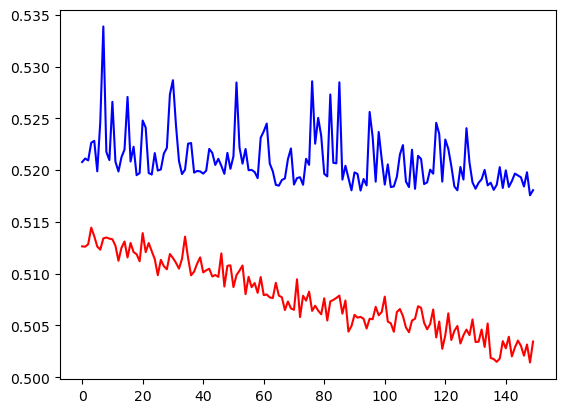

In [25]:
print(IMDB_history)
plt.plot(range(nepoch),IMDB_history.history['loss'],c='r')
plt.plot(range(nepoch),IMDB_history.history['val_loss'],c='b')
plt.plot()

[]

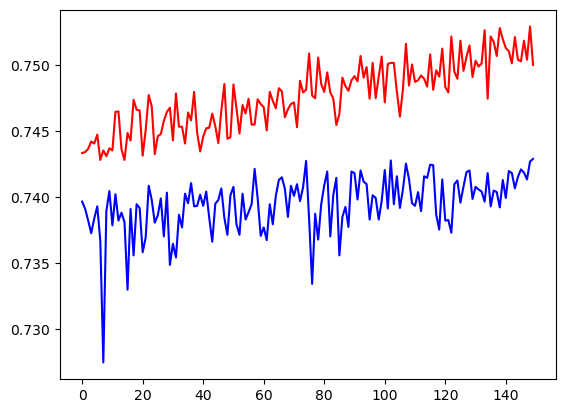

In [27]:
plt.plot(range(nepoch), IMDB_history.history['accuracy'], c='r')
plt.plot(range(nepoch), IMDB_history.history['val_accuracy'], c='b')
plt.plot()

# ORIGINAL
The history for the model above has been saved, as it takes a while to run. If you want to run it yourself then comment out the second line.


[]

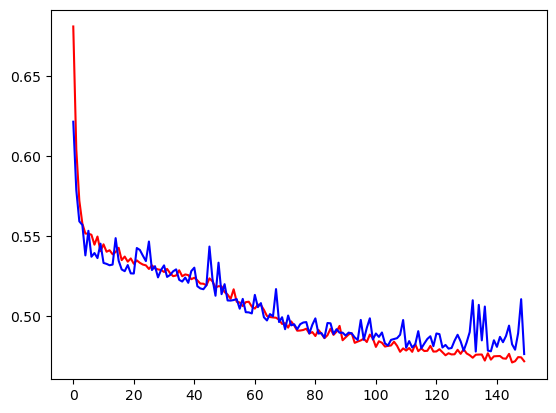

In [28]:
nepoch = 150
IMDB_history_original=np.load('IMDBTrainhist.npy',allow_pickle='TRUE').item()
print(IMDB_history)
plt.plot(range(nepoch),IMDB_history_original['loss'],c='r')
plt.plot(range(nepoch),IMDB_history_original['val_loss'],c='b')
plt.plot()

[]

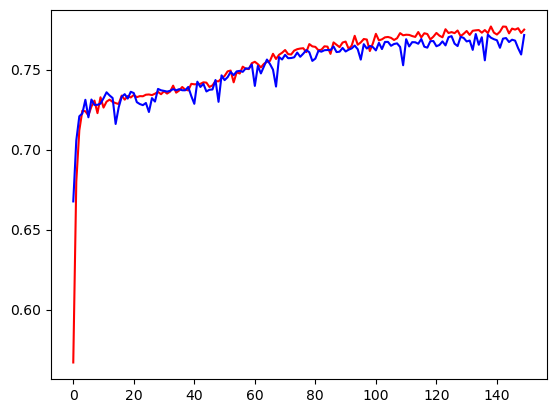

In [29]:
plt.plot(range(nepoch),IMDB_history_original['accuracy'],c='r')
plt.plot(range(nepoch),IMDB_history_original['val_accuracy'],c='b')
plt.plot()

### Final Submission (complete by Sunday 19/02/23)

Submit Tasks 1-5 in a single notebook this before the deadline on Sunday.


In [ ]:
## Add additional code cells to implememt the tasks stated above 

## Reflection

There are no specific marks allocated for a reflection. However due consideration will be given if pertinent comments or valuable insights are made.